In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline
from ydata_profiling import ProfileReport
import logging

import json
from enum import Enum

%matplotlib inline

plt.style.use(r'C:\LibsAndApps\Python config files\proplot_style.mplstyle')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

logging.basicConfig(format='%(asctime)s %(message)s', filename='logger.log',
    filemode='a', encoding='utf-8', level=logging.DEBUG)

Import election data from 2024:

In [22]:
df_c = pd.read_excel('real_data/HoC-GE2024-results-by-candidate.xlsx', sheet_name='Data', skiprows=2)
#ProfileReport(df_c)

Preprocessing:

In [23]:
# put independent candidates into their own individual parties
ind = df_c['Party name'] == 'Independent'
df_c.loc[ind, 'Party name'] = 'Independent - ' + df_c.loc[ind, 'Candidate first name'] + ' ' + df_c.loc[ind, 'Candidate surname']

# sum votes for each party
df_p = pd.DataFrame()
df_p = df_c.groupby('Party name').Votes.sum().reset_index()
df_p.sort_values('Votes', ascending=False, inplace=True, ignore_index=True)

NUM_SEATS = df_c['Constituency name'].nunique()

Calculate seats using First Past the Post (FPTP):

In [24]:
def calculate_FPTP(df_c: pd.DataFrame, df_p: pd.DataFrame) -> tuple[dict, dict, float]:
    '''
    Calculate the results of General Election 2024 using the First Past The Post (FPTP) voting system.
    Candidates with the most votes in each constituency win a seat for their party.
    
    ### Arguments
    #### Required
    - `df_c` (pd.DataFrame): voting data, by candidate
    - `df_p` (pd.DataFrame): summarised aggregate voting data, by party
    
    ### Returns
    - `tuple[dict, dict, float]`: 
    1) mapping of constituency name to winning party, 
    2) mapping of party name to number of seats in Parliament won,
    3) deviation from proportionality
    '''    

    # identify winning party in each constituency
    df_fptp = pd.DataFrame()
    df_fptp = df_c.groupby('Constituency name').Votes.idxmax()
    df_fptp = df_c.loc[df_fptp, ['Constituency name', 'Party name']]
    df_fptp.rename(columns={'Party name': 'Winning party'}, inplace=True)

    # absorb 'Labour and Cooperative' party into 'Labour'
    df_fptp.loc[df_fptp['Winning party'] == 'Labour and Co-operative', 'Winning party'] = 'Labour'
    
    results_fptp = {seat: party for seat, party in zip(df_fptp['Constituency name'], df_fptp['Winning party'])}
    seats_allocated_fptp = {party: df_fptp.loc[df_fptp['Winning party'] == party].shape[0] for party in df_p['Party name']}

    # calculate deviation from proportionality
    dv_fptp = 1/2 * sum([abs(df_p.loc[df_p['Party name'] == party, 'Votes'].values[0] / df_p['Votes'].sum() -
        seats_allocated_fptp[party] / NUM_SEATS) for party in seats_allocated_fptp.keys()])

    # remove parties with no seats from record
    seats_allocated_fptp = {party: seats for party, seats in seats_allocated_fptp.items() if seats > 0}
    
    return (results_fptp, seats_allocated_fptp, dv_fptp)
    
results_fptp, seats_allocated_fptp, dv_fptp = calculate_FPTP(df_c, df_p)

print('Results using FPTP:')
print(seats_allocated_fptp)
print(f'Deviation from proportionality: {dv_fptp:.2%}')
# decide results based on seats
# calculate working majority: 650 minus 1 speaker, 3 deputy speakers and the Sinn Fein MPs
working_majority_fptp = (NUM_SEATS - 4 - seats_allocated_fptp.get('Sinn Féin', 0)) // 2 + 1
if any([seats_allocated_fptp.get(party, 0) >= working_majority_fptp for party in seats_allocated_fptp.keys()]):
    winning_party_fptp = max(seats_allocated_fptp, key=seats_allocated_fptp.get)
    print(f'Result: {winning_party_fptp} wins, {seats_allocated_fptp[winning_party_fptp]} seats > {working_majority_fptp} working majority')
else:
    winning_party_fptp = None
    print(f'Coalition required: no party has the working majority of {working_majority_fptp} seats')

Results using FPTP:
{'Labour': 411, 'Conservative': 121, 'Reform UK': 5, 'Liberal Democrat': 72, 'Green': 4, 'Scottish National Party': 9, 'Sinn Fein': 7, 'Plaid Cymru': 4, 'Democratic Unionist Party': 5, 'Alliance': 1, 'Ulster Unionist Party': 1, 'Social Democratic and Labour Party': 2, 'Traditional Unionist Voice': 1, 'Speaker': 1, 'Independent - Jeremy Corbyn': 1, 'Independent - Alex Easton': 1, 'Independent - Iqbal Mohamed': 1, 'Independent - Shockat Adam': 1, 'Independent - Ayoub Khan': 1, 'Independent - Adnan Hussain': 1}
Deviation from proportionality: 33.65%
Result: Labour wins, 411 seats > 324 working majority


Calculate seats using Proportional Past the Post (PPP):

In [25]:
def calculate_PPP(df_c: pd.DataFrame, df_p: pd.DataFrame) -> tuple[dict, dict, float]:
    '''
    Calculate the results of General Election 2024 using the Proportional Past the Post (PPP) voting system.
    Candidates ranked most highly win for their party in each constituency, until the party has met its quota of seats.
    
    ### Arguments
    #### Required
    - `df_c` (pd.DataFrame): voting data, by candidate
    - `df_p` (pd.DataFrame): summarised aggregate voting data, by party
    
    ### Returns
    - `tuple[dict, dict, float]`: 
    1) mapping of constituency name to winning party, 
    2) mapping of party name to number of seats in Parliament won,
    3) deviation from proportionality
    '''    

    df_p['Quota'] = np.ceil(df_p['Votes'] / df_p['Votes'].sum() * NUM_SEATS)
    df_p['Quota'] = df_p['Quota'].astype(int)

    # sort by vote share in each constituency
    df_c = df_c.sort_values(by='Share', ascending=False)

    # listing the order
    #print(df_c[['Constituency name', 'Party name', 'Votes', 'Share']].iloc[431:438])

    # allocate seats to each party
    results_ppp = {seat: None for seat in df_c['Constituency name'].unique()}
    seats_allocated_ppp = {party: 0 for party in df_p['Party name'].unique()}
    for _, row in df_c.iterrows():
        constituency = row['Constituency name']
        party = row['Party name']
        if results_ppp[constituency] is not None:  # constituency already allocated
            logging.info(f'Trying to allocate {party} to {constituency} but already allocated to {results_ppp[constituency]}')
            continue
        if seats_allocated_ppp[party] >= df_p.loc[df_p['Party name'] == party, 'Quota'].values[0]:  # party already met quota
            logging.info(f'Trying to allocate {party} to {constituency} but already met quota of {df_p.loc[df_p["Party name"] == party, "Quota"].values[0]}')
            continue
        logging.info(f'Allocating {party} to {constituency}')
        results_ppp[constituency] = party
        seats_allocated_ppp[party] += 1

    # any unallocated seats go to party with highest total vote
    leading_party = df_p.iloc[0, 0]
    num_nones = list(results_ppp.values()).count(None)
    logging.info(f'Allocating {num_nones} unallocated seats to {leading_party}: {[k for k, v in results_ppp.items() if v is None]}')
    results_ppp = {k: (v if v is not None else leading_party) for k, v in results_ppp.items()}
    seats_allocated_ppp[leading_party] += num_nones
    
    # absorb 'Labour and Cooperative' party into 'Labour'
    for seat, party in results_ppp.items():
        if party == 'Labour and Co-operative':
            results_ppp[seat] = 'Labour'
    seats_allocated_ppp['Labour'] = seats_allocated_ppp.get('Labour', 0) + seats_allocated_ppp.get('Labour and Co-operative', 0)
    del seats_allocated_ppp['Labour and Co-operative']

    # calculate deviation from proportionality
    dv_ppp = 1/2 * sum([abs(df_p.loc[df_p['Party name'] == party, 'Votes'].values[0] / df_p['Votes'].sum() -
        seats_allocated_ppp[party] / NUM_SEATS) for party in seats_allocated_ppp.keys()])

    # remove parties with no seats from record
    seats_allocated_ppp = {k: v for k, v in seats_allocated_ppp.items() if v > 0}
    
    return (results_ppp, seats_allocated_ppp, dv_ppp)

results_ppp, seats_allocated_ppp, dv_ppp = calculate_PPP(df_c, df_p)

print('Results using PPP:')
print(seats_allocated_ppp)
print(f'Total seats: {sum(seats_allocated_ppp.values())}')

print(f'Deviation from proportionality (PPP): {dv_ppp:.2%}')
# decide results based on seats
# calculate working majority: 650 minus 1 speaker, 3 deputy speakers and the Sinn Féin MPs
working_majority_ppp = (NUM_SEATS - 4 - seats_allocated_ppp.get('Sinn Féin', 0)) // 2 + 1
if any([seats_allocated_ppp.get(party, 0) >= working_majority_ppp for party in seats_allocated_ppp.keys()]):
    winning_party_ppp = max(seats_allocated_ppp, key=seats_allocated_ppp.get)
    print(f'Result: {winning_party_ppp} wins, {seats_allocated_ppp[winning_party_ppp]} seats > {working_majority_ppp} working majority')
else:
    winning_party_ppp = None
    print(f'Coalition required: no party has the working majority of {working_majority_ppp} seats')

Results using PPP:
{'Labour': 220, 'Conservative': 155, 'Reform UK': 93, 'Liberal Democrat': 80, 'Green': 33, 'Scottish National Party': 17, 'Sinn Fein': 5, 'Workers Party of Britain': 4, 'Plaid Cymru': 5, 'Democratic Unionist Party': 4, 'Alliance': 3, 'Ulster Unionist Party': 1, 'Scottish Green Party': 2, 'Social Democratic and Labour Party': 2, 'Traditional Unionist Voice': 2, 'Speaker': 1, 'Independent - Jeremy Corbyn': 1, 'Independent - Alex Easton': 1, 'Independent - Iqbal Mohamed': 1, 'Independent - Leanne Mohamad': 1, 'Independent - Shockat Adam': 1, 'Independent - Ajmal Masroor': 1, 'Independent Network': 1, 'Independent - Ayoub Khan': 1, 'Independent - Muhammed Islam': 1, 'Independent - Adnan Hussain': 1, 'Independent - Noor Begum': 1, 'Independent - Michael Lavalette': 1, 'Independent - Zaffar Iqbal': 1, 'Independent - Talat Sajawal': 1, 'Independent - Aftab Nawaz': 1, 'Independent - Shakeel Afsar': 1, 'Independent - Claudia Webbe': 1, 'Independent - Attiq Malik': 1, 'Indepen

Calculate seats using Proportional Representation (PR):

In [26]:
class PR_Method(Enum):
    D_HONDT = 1
    SAINT_LAGUE = 2


def calculate_PR(df_p: pd.DataFrame, num_seats: int = NUM_SEATS,
        method: int = PR_Method.D_HONDT) -> tuple[dict, float]:
    '''
    Calculate the results of General Election 2024 using the Proportional Representation (PR) voting system.
    Seats are allocated to parties based only on the total votes received, using the d'Hondt or Sainte-Laguë method.
    Constituencies are not used in PR - only the total votes are used to form the results.
    
    ### Arguments
    #### Required
    - `df_p` (pd.DataFrame): summarised aggregate voting data, by party
    #### Optional
    - `num_seats` (int, default = NUM_SEATS): total number of seats to allocate (default: 650)
    - `method` (int, default = PR_Method.D_HONDT): either PR_Method.D_HONDT or PR_Method.SAINT_LAGUE
    for the d'Hondt or Sainte-Laguë method respectively, using different divisors to calculate the quotient
    
    ### Returns
    - `tuple[dict, float]`:
    1) mapping of party name to number of seats in Parliament won,
    2) deviation from proportionality
    '''    

    df_p['Seats_PR'] = 0
    seats_allocated_pr = {party: 0 for party in df_p['Party name'].unique()}

    match method:
        case PR_Method.D_HONDT:
            divisor = 1
        case PR_Method.SAINT_LAGUE:
            divisor = 2

    for _ in range(num_seats):
        df_p['Quotient'] = (df_p['Votes'] / (divisor * df_p['Seats_PR'] + 1)).astype(int)
        winner = df_p.loc[df_p['Quotient'].idxmax(), 'Party name']
        seats_allocated_pr[winner] += 1
        df_p.loc[df_p['Party name'] == winner, 'Seats_PR'] += 1

    # absorb 'Labour and Cooperative' party into 'Labour'
    del seats_allocated_pr['Labour and Co-operative']
    df_p.loc[df_p['Party name'] == 'Labour', 'Votes'] += df_p.loc[df_p['Party name'] == 'Labour and Co-operative', 'Votes'].values[0]
    df_p.loc[df_p['Party name'] == 'Labour', 'Seats_PR'] += df_p.loc[df_p['Party name'] == 'Labour and Co-operative', 'Seats_PR'].values[0]
    df_p.drop(df_p.loc[df_p['Party name'] == 'Labour and Co-operative'].index, inplace=True)
    
    # calculate deviation from proportionality
    dv_pr = 1/2 * sum([abs(df_p.loc[df_p['Party name'] == party, 'Votes'].values[0] / df_p['Votes'].sum() -
        seats_allocated_pr[party] / num_seats) for party in seats_allocated_pr.keys()])

    # remove parties with no seats from record
    seats_allocated_pr = {k: v for k, v in seats_allocated_pr.items() if v > 0}
    
    return (seats_allocated_pr, dv_pr)

seats_allocated_pr, dv_pr = calculate_PR(df_p, method=PR_Method.SAINT_LAGUE)

print(f'Results using PR (Sainte-Laguë method)')  # Sainte-Laguë or d'Hondt
print(seats_allocated_pr)
print(f'Deviation from proportionality (PR): {dv_pr:.2%}')
# decide results based on seats
# calculate working majority: 650 minus 1 speaker, 3 deputy speakers and the Sinn Féin MPs
working_majority_pr = (NUM_SEATS - 4 - seats_allocated_pr.get('Sinn Féin', 0)) // 2 + 1
if any([seats_allocated_pr.get(party, 0) >= working_majority_pr for party in seats_allocated_pr.keys()]):
    winning_party_pr = max(seats_allocated_pr, key=seats_allocated_pr.get)
    print(f'Result: {winning_party_pr} wins, {seats_allocated_pr[winning_party_pr]} seats > {working_majority_pr} working majority')
else:
    winning_party_pr = None
    print(f'Coalition required: no party has the working majority of {working_majority_pr} seats')

Results using PR (Sainte-Laguë method)
{'Labour': 205, 'Conservative': 158, 'Reform UK': 95, 'Liberal Democrat': 81, 'Green': 43, 'Scottish National Party': 17, 'Sinn Fein': 5, 'Workers Party of Britain': 5, 'Plaid Cymru': 4, 'Democratic Unionist Party': 4, 'Alliance': 3, 'Ulster Unionist Party': 2, 'Scottish Green Party': 2, 'Social Democratic and Labour Party': 2, 'Traditional Unionist Voice': 1, 'Social Democratic Party': 1, 'Speaker': 1, 'Independent - Jeremy Corbyn': 1}
Deviation from proportionality (PR): 3.33%
Coalition required: no party has the working majority of 324 seats


Plots:

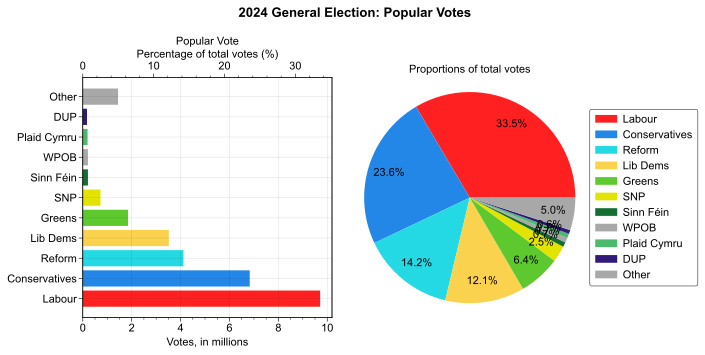

In [27]:
num_top = 10
top = df_p.head(num_top)
top = pd.concat([top, pd.DataFrame([['Other', df_p.loc[num_top:, 'Votes'].sum()]],
    columns=['Party name', 'Votes'])], ignore_index=True)

keys = json.load(open('main_parties.json'))

def name(party: str) -> str:
    if party in keys:
        return keys[party]['name']
    if 'Independent - ' in party:
        return party.split(' - ')[-1]
    if len(party.split()) >= 3:
        return ''.join([word[0].upper() for word in party.split()])
    if len(party) > 18:
        return party[:15] + '...'
    return party


fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.barh([name(p) for p in top['Party name']], top['Votes'] / 1e6,
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in top['Party name']])
ax1.set_xlabel('Votes, in millions')
ax1.set_title('Popular Vote')
ax1t = ax1.twiny()
ax1t.barh([name(p) for p in top['Party name']], top['Votes'] / top['Votes'].sum() * 100,
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in top['Party name']], alpha=0)
ax1t.grid(False)
ax1t.set_xlabel('Percentage of total votes (%)')
ax1.yaxis.set_minor_locator(plt.NullLocator())

ax2.pie(top['Votes'],
    colors=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in top['Party name']],
    radius=1.1, autopct='%1.1f%%', pctdistance=0.8)
ax2.legend([name(p) for p in top['Party name']], loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Proportions of total votes')

fig1.suptitle('2024 General Election: Popular Votes')
fig1.tight_layout()
fig1.savefig('figures/2024_general_election_popular_votes.svg')
plt.show()

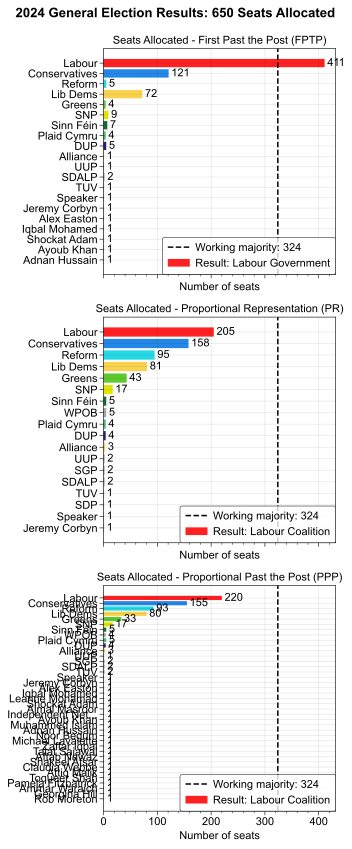

In [28]:
fig2, (ax3, ax4, ax5) = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

# plot FPTP results
ax3.barh([name(p) for p in seats_allocated_fptp.keys()],
    seats_allocated_fptp.values(), 
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in seats_allocated_fptp.keys()])
ax3.set_xlabel('Number of seats')
ax3.set_title('Seats Allocated - First Past the Post (FPTP)')
ax3.invert_yaxis()
for i, (party, seats) in enumerate(seats_allocated_fptp.items()):
    ax3.text(seats + 5, i, f'{seats}', va='center', ha='left')
ax3.axvline(working_majority_fptp, color='black', linestyle='--', 
    label=f'Working majority: {working_majority_fptp}')
if winning_party_fptp is not None:
    ax3.barh([name(winning_party_fptp)], [1],
        color=[keys[winning_party_fptp]['colour']], label=f'Result: {winning_party_fptp} Government')
else:
    leading_party_fptp = max(seats_allocated_fptp, key=seats_allocated_fptp.get)
    ax3.barh([name(leading_party_fptp)], [1],
        color=[keys[leading_party_fptp]['colour']], label=f'Result: {leading_party_fptp} Coalition')
ax3.yaxis.set_minor_locator(plt.NullLocator())
ax3.legend()

# plot PR results
ax4.barh([name(p) for p in seats_allocated_pr.keys()],
    seats_allocated_pr.values(),
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in seats_allocated_pr.keys()])
ax4.set_xlabel('Number of seats')
ax4.set_title('Seats Allocated - Proportional Representation (PR)')
ax4.invert_yaxis()
for i, (party, seats) in enumerate(seats_allocated_pr.items()):
    ax4.text(seats + 5, i, f'{seats}', va='center', ha='left')
ax4.axvline(working_majority_pr, color='black', linestyle='--',
    label=f'Working majority: {working_majority_pr}')
if winning_party_pr is not None:
    ax4.barh([name(winning_party_pr)], [1],
        color=[keys[winning_party_pr]['colour']], label=f'Result: {winning_party_pr} Government')
else:
    leading_party_pr = max(seats_allocated_pr, key=seats_allocated_pr.get)
    ax4.barh([name(leading_party_pr)], [1],
        color=[keys[leading_party_pr]['colour']], label=f'Result: {leading_party_pr} Coalition')
ax4.yaxis.set_minor_locator(plt.NullLocator())
ax4.legend()

# plot PPP results
ax5.barh([name(p) for p in seats_allocated_ppp.keys()],
    seats_allocated_ppp.values(),
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in seats_allocated_ppp.keys()])
ax5.set_xlabel('Number of seats')
ax5.set_title('Seats Allocated - Proportional Past the Post (PPP)')
ax5.invert_yaxis()
for i, (party, seats) in enumerate(seats_allocated_ppp.items()):
    ax5.text(seats + 5, i, f'{seats}', va='center', ha='left')
ax5.axvline(working_majority_ppp, color='black', linestyle='--',
    label=f'Working majority: {working_majority_ppp}')
if winning_party_ppp is not None:
    ax5.barh([name(winning_party_ppp)], [1],
        color=[keys[winning_party_ppp]['colour']], label=f'Result: {winning_party_ppp} Government')
else:
    leading_party_ppp = max(seats_allocated_ppp, key=seats_allocated_ppp.get)
    ax5.barh([name(leading_party_ppp)], [1],
        color=[keys[leading_party_ppp]['colour']], label=f'Result: {leading_party_ppp} Coalition')
ax5.yaxis.set_minor_locator(plt.NullLocator())
ax5.legend()

fig2.suptitle('2024 General Election Results: 650 Seats Allocated')
fig2.tight_layout(rect=[0, 0, 1, 0.99])
fig2.savefig('figures/2024_general_election_results.svg')
plt.show()

Calculate proportionality for each top party for each system:

C:\Users\lnick\AppData\Local\Temp\ipykernel_28144\1938608914.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['_'] + [name(n) for n in df_p['Party name']], ha='center')


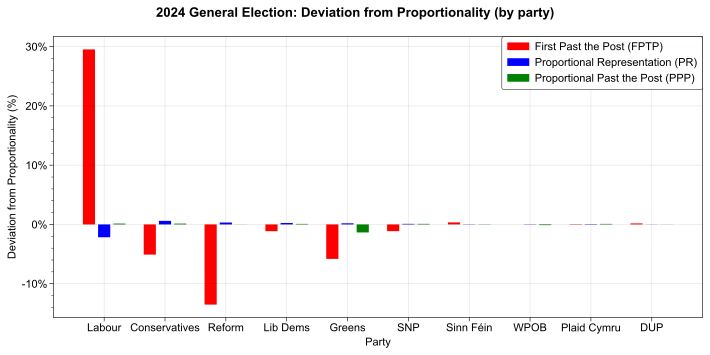

In [29]:
df_p['Votes %'] = df_p['Votes'] / df_p['Votes'].sum()
df_p['% S-V FPTP'] = df_p['Party name'].map(seats_allocated_fptp) / NUM_SEATS - df_p['Votes %']
df_p['% S-V PR'] = df_p['Party name'].map(seats_allocated_pr) / NUM_SEATS - df_p['Votes %']
df_p['% S-V PPP'] = df_p['Party name'].map(seats_allocated_ppp) / NUM_SEATS - df_p['Votes %']
df_p.fillna(0, inplace=True)
df_p = df_p[df_p['Party name'].isin(top['Party name'])]

fig3, ax = plt.subplots(figsize=(10, 5))
x = np.arange(0, df_p.shape[0], 1)
ax.bar(x - 0.25, df_p['% S-V FPTP'], color='red',
    label='First Past the Post (FPTP)', width=0.2)
ax.bar(x, df_p['% S-V PR'], color='blue',
    label='Proportional Representation (PR)', width=0.2)
ax.bar(x + 0.25, df_p['% S-V PPP'], color='green',
    label='Proportional Past the Post (PPP)', width=0.2)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels(['_'] + [name(n) for n in df_p['Party name']], ha='center')
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel('Party')
ax.set_ylabel('Deviation from Proportionality (%)')
ax.legend()
fig3.suptitle('2024 General Election: Deviation from Proportionality (by party)')
fig3.tight_layout()
fig3.savefig('figures/2024_general_election_deviation.svg')

plt.show()

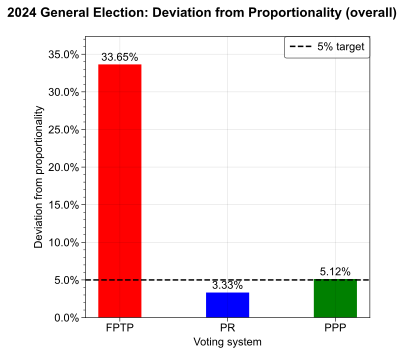

In [30]:
fig4, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.bar(['FPTP', 'PR', 'PPP'], [dv_fptp, dv_pr, dv_ppp], color=['red', 'blue', 'green'], width=0.4)
ax.axhline(0.05, color='black', linestyle='--', label='5% target')
ax.set_xlabel('Voting system')
ax.set_ylabel('Deviation from proportionality')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
for i, dv in enumerate([dv_fptp, dv_pr, dv_ppp]):
    ax.text(i, dv + 0.005, f'{dv:.2%}', ha='center')
ax.set_ylim(top=ax.get_ylim()[1] + 0.02)
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.legend()

fig4.suptitle('2024 General Election: Deviation from Proportionality (overall)')
fig4.tight_layout()
fig4.savefig('figures/2024_general_election_proportionality.svg')
plt.show()